This notebooks compares the execution times of new and old posprocessing methods.
It generates fake data to run the postprocessing.

In [20]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import line_profiler as lp
import drawing
import importlib

import sys
sys.path.append('..')
from src import postprocessing as pp

In [ ]:
#old versions of posprocessing functions
import time
def cgm_transform_old(cgm_data):
    """
    Time aligns the cgm data to midnight with a 5 minute sampling rate.

    Parameters:
        cgm_data (DataFrame): The input is a cgm data dataframe containing columns 'patient_id, 'datetime', and 'cgm'.

    Returns:
        cgm_data (DataFrame): The transformed cgm data with aligned timestamps.
    """
    #start data from midnight
    cgm_data = cgm_data.sort_values(by='datetime').reset_index(drop=True)
    cgm_data['datetime'] = cgm_data['datetime'].dt.round("5min")
    cgm_data['UnixTime'] = [int(time.mktime(cgm_data.datetime[x].timetuple())) for x in cgm_data.index]

    start_date = cgm_data['datetime'].iloc[0].date()
    end_date = cgm_data['datetime'].iloc[-1].date() + timedelta(days=1)
    
    cgm_from_mid = pd.DataFrame(columns=['datetime_adj'])
    cgm_from_mid['datetime_adj'] = pd.date_range(start = start_date, end = end_date, freq="5min").values

    cgm_from_mid['UnixTime'] = [int(time.mktime(cgm_from_mid.datetime_adj[x].timetuple())) for x in cgm_from_mid.index]
    cgm_from_mid = cgm_from_mid.drop_duplicates(subset=['UnixTime']).sort_values(by='UnixTime')
    cgm_data = cgm_data.drop_duplicates(subset=['UnixTime']).sort_values(by='UnixTime')

    #merge new time with cgm data
    cgm_merged = pd.merge_asof(cgm_from_mid, cgm_data, on="UnixTime",direction="nearest",tolerance=149)

    cgm_data = cgm_merged.filter(items=['datetime_adj','cgm'])
    cgm_data = cgm_data.rename(columns={"datetime_adj": "datetime"}) 
    
    #replace not null values outside of 40-400 range with 40 or 400
    cgm_data.loc[cgm_data['cgm'] < 40, 'cgm'] = 40
    cgm_data.loc[cgm_data['cgm'] > 400, 'cgm'] = 400
    
    return cgm_data

def _durations_since_previous_valid_value(dates, values):
    """
    Calculate the durations between each date and the previous date with a valid value (non NaN).

    Parameters:
        dates (list): A list of dates.
        values (list): A list of values.

    Returns:
        list: A list of durations between each date and the previous valid date. NaN if there is no previous valid date.
    """
    last_valid_date = None
    durations = []
    for (date, value) in zip(dates, values):
        duration = np.NaN
        if last_valid_date is not None:
            duration = date - last_valid_date
        if not np.isnan(value):
            last_valid_date = date
        durations.append(duration)
    return durations

def _combine_and_forward_fill(basal_df, gap=float('inf')):
    # forward fill, but only if duration between basal values is smaller than the threshold
    durations = _durations_since_previous_valid_value(basal_df['datetime'], basal_df['basal_delivery'])
    bSignificantGap = [True if pd.notna(
                        duration) and duration >= gap else False for duration in np.array(durations)]
    basal_df['basal_delivery'] = basal_df['basal_delivery'].where(
                        bSignificantGap, basal_df['basal_delivery'].ffill())
    return basal_df


def basal_transform_old(basal_data):
    """
    Transform the basal data by aligning timestamps and handling duplicates.

    Parameters:
        basal_data (DataFrame): The input is a basal data dataframe containing columns 'datetime', and 'basal_rate'.

    Returns:
        basal_data (DataFrame): The transformed basal equivalent deliveries with aligned timestamps and duplicates removed.
    """
    #start data from midnight
    basal_data = basal_data.sort_values(by='datetime').reset_index(drop=True)
    basal_data['datetime'] = basal_data['datetime'].dt.round("5min")
    basal_data['UnixTime'] = [int(time.mktime(basal_data.datetime[x].timetuple())) for x in basal_data.index]

    start_date = basal_data['datetime'].iloc[0].date()
    end_date = basal_data['datetime'].iloc[-1].date() + timedelta(days=1)
    
    basal_from_mid = pd.DataFrame(columns=['datetime_adj'])
    basal_from_mid['datetime_adj'] = pd.date_range(start = start_date, end = end_date, freq="5min").values

    basal_from_mid['UnixTime'] = [int(time.mktime(basal_from_mid.datetime_adj[x].timetuple())) for x in basal_from_mid.index]
    basal_from_mid = basal_from_mid.drop_duplicates(subset=['UnixTime']).sort_values(by='UnixTime')
    #keep last basal rate if there is a duplicate time
    basal_data = basal_data.drop_duplicates(subset='UnixTime',keep='last')
    #merge new time with basal data
    basal_data = basal_data.sort_values(by='UnixTime')
    basal_merged = pd.merge_asof(basal_from_mid, basal_data, on="UnixTime", direction="nearest", tolerance=149)

    basal_data = basal_merged.filter(items=['datetime_adj','basal_rate'])
    basal_data = basal_data.rename(columns={"datetime_adj": "datetime"}) 

    #convert basal rate to 5 minute deliveries
    basal_data = basal_data.assign(basal_delivery = basal_data.basal_rate/12).drop(columns='basal_rate')
    
    # forward fill (only up to 24 hours)
    basal_data = _combine_and_forward_fill(basal_data, gap=timedelta(hours=24))
    
    return basal_data


# Function to split the bolus into multiple deliveries
def split_bolus(datetime, bolus, duration, sampling_frequency):
    steps = max(1, np.ceil(duration / pd.to_timedelta(sampling_frequency)))
    delivery_per_interval = bolus / steps
    times = pd.date_range(start=datetime, end=datetime + duration, freq=sampling_frequency, inclusive='left')
    deliveries = [delivery_per_interval] * len(times)
    return {'datetime': times, 'delivery': deliveries}

#functions for time alignment and transformation of basal, bolus, and cgm event data. These functions can be used for any study dataset.
def bolus_transform_old(df):
    """
    Transform the bolus data by aligning timestamps, handling duplicates, and extending boluses based on durations.

    Parameters:
        df (DataFrame): The input is a bolus data dataframe containing columns 'datetime', 'bolus', and 'delivery_duration'.

    Returns:
        bolus_data (DataFrame): 5 Minute resampled and time aligned at midnight bolus data with columns: datetime, delivery
    """

    sampling_frequency = '5min'

    expanded_rows = [split_bolus(row['datetime'], row['bolus'], row['delivery_duration'], sampling_frequency) for _, row in df.iterrows()]
    
    # Concatenate the lists of datetimes and deliveries
    datetimes = np.concatenate([item['datetime'] for item in expanded_rows])
    deliveries = np.concatenate([item['delivery'] for item in expanded_rows])
    expanded_events = pd.DataFrame({'datetime': datetimes, 'bolus': deliveries})
    
    # Round down to the nearest floored interval
    expanded_events['datetime'] = expanded_events['datetime'].dt.floor(sampling_frequency)
    
    # Sum up multiple entries for the same time
    expanded_events = expanded_events.groupby('datetime').sum().reset_index()
    
    # Resample to ensure all intervals are present
    start_time = df['datetime'].min().floor('D')  # Starting midnight
    end_time = (df['datetime'] + df['delivery_duration']).max().ceil('D')  # Ending at midnight next day
    all_times = pd.date_range(start=start_time, end=end_time, freq=sampling_frequency, inclusive='left')
    resampled_deliveries = expanded_events.set_index('datetime').reindex(all_times, fill_value=0).reset_index(drop=False, names =['datetime'])
    
    return resampled_deliveries


## CGM

In [9]:

# Parameters
num_days = 50
num_patients = 5
sample_freq = '5T'  # 5 minutes

# Generate datetime range for each day with a gap of 4 hours
def generate_datetime_range(start_date, num_days, sample_freq):
    date_ranges = []
    start = start_date
    end = start
    while (end-start) < timedelta(days=num_days):
        a = end + timedelta(hours=np.random.randint(1, 12))
        end = a + timedelta(hours=np.random.randint(1, 12))
        date_ranges.append(pd.date_range(a, end, freq=sample_freq))
    return pd.DatetimeIndex(np.concatenate(date_ranges))

# Generate sine curve CGM values
def generate_cgm_values(num_samples):
    x = np.linspace(0, 2 * np.pi, num_samples)
    return 100 + 20 * np.sin(x)  # Sine curve with mean 100 and amplitude 20

# Generate data for each patient
data = []
start_date = datetime(2023, 1, 1)
for patient_id in range(1, num_patients + 1):
    datetimes = generate_datetime_range(start_date, num_days, sample_freq)
    cgm_values = np.array([75 + 50 * (1+np.sin((x-datetimes.min()).total_seconds() / (24*3600))) for x in datetimes])
    cgm_values = cgm_values + np.random.normal(0, 5, len(cgm_values))
    
    patient_data = pd.DataFrame({
        'datetime': datetimes,
        'patient_id': [f'Patient_{patient_id}'] * len(datetimes),
        'cgm': cgm_values
    })
    data.append(patient_data)

# Concatenate all patient data into a single DataFrame
df = pd.concat(data).reset_index(drop=True)

from line_profiler import LineProfiler
lp = LineProfiler()
lp.add_function(pp.cgm_transform)
lp.add_function(cgm_transform_old)

lp_wrapper = lp(df.groupby('patient_id').apply)
res= lp_wrapper(pp.cgm_transform, include_groups=False)
res_old = lp_wrapper(cgm_transform_old, include_groups=False)

# Calculate and print the difference in total execution times
stats = lp.get_stats()
for key in stats.timings.keys():
    #print(sum([t[2] for t in stats.timings[key]]))
    print(key[0])
    print(f'Execution time {sum([t[2] for t in stats.timings[key]])/1000000000:.6f} seconds')

/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_74138/3057124978.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_ranges.append(pd.date_range(a, end, freq=sample_freq))


/Users/jan/git/nudgebg/egvinsulin/notebooks/../src/postprocessing.py
Execution time 0.017917 seconds
/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_74138/4050518867.py
Execution time 1.877462 seconds
/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/pandas/core/groupby/groupby.py
Execution time 1.905939 seconds


/Users/jan/git/nudgebg/egvinsulin/notebooks/../src/postprocessing.py
Execution time 0.013953 seconds
/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_74138/4050518867.py
Execution time 0.080872 seconds


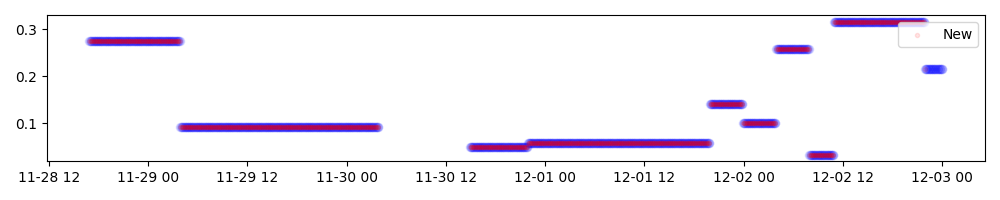

In [ ]:
datetimes = [datetime.now()-timedelta(days=4)]
while datetimes[-1] < datetime.now():
    datetimes.append(datetimes[-1]+timedelta(hours=np.random.randint(1, 16)))

df = pd.DataFrame({'datetime': datetimes, 'basal_rate': np.random.randint(0,40,len(datetimes))/10})

df.drop(df.sample(df.shape[0]//3).index, inplace=True)

lp = LineProfiler()
lp.add_function(pp.basal_transform)
lp.add_function(basal_transform_old)

basal_transform_old_wrapper = lp.wrap_function(basal_transform_old)
res_old = basal_transform_old_wrapper(df)
basal_transform_wrapper = lp.wrap_function(pp.basal_transform)
res = basal_transform_wrapper(df)

# Calculate and print the difference in total execution times
stats = lp.get_stats()
#lp.print_stats()
for key in stats.timings.keys():
    #print(sum([t[2] for t in stats.timings[key]]))
    print(key[0])
    print(f'Execution time {sum([t[2] for t in stats.timings[key]])/1000000000:.6f} seconds')

plt.figure(figsize=(10,2))
ax = plt.gca()
ax.scatter(res_old['datetime'], res_old['basal_delivery'], marker='o',color='blue',alpha=0.1)
ax.scatter(res.datetime, res['basal_delivery'], label='New',marker='.',color='red',alpha=0.1)
plt.legend()
plt.tight_layout()

## Bolus

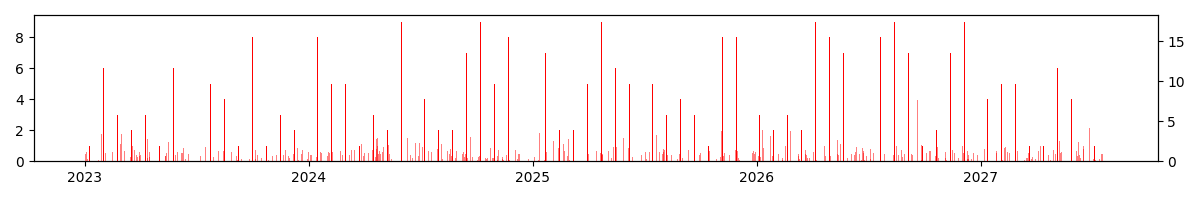

(19358.0, 19363.0)

In [38]:
importlib.reload(drawing)
%matplotlib widget

#test data for bolus deliveries
samples = 10000
durations = np.random.choice([0,1],samples,p=[0.7,0.3])*np.random.randint(30, 8*60, samples)

df_bolus = pd.DataFrame({'datetime': pd.date_range(start='2023-01-01', periods=samples, freq='4h'), 
              'bolus': np.random.randint(1, 10, samples),
              'delivery_duration': pd.to_timedelta(durations, unit='min')})
df_bolus['datetime'] = pd.to_datetime(df_bolus['datetime'])

plt.figure(figsize=(12,2)); ax = plt.gca(); twinax = ax.twinx()
drawing.drawBoluses(ax, df_bolus.datetime, df_bolus.bolus)
extended = df_bolus.loc[df_bolus.delivery_duration>pd.Timedelta(0)]
drawing.drawExtendedBoluses(twinax, extended.datetime.values, extended.bolus.values, extended.delivery_duration.values)
plt.tight_layout(); plt.show(); ax.set_ylim(0, 10);twinax.set_ylim(0, 10); 
ax.set_xlim((df_bolus.datetime.min(), df_bolus.datetime.min()+pd.Timedelta(5, unit='D')))

In [ ]:

# Function to split the bolus into multiple deliveries
def split_bolus_new(datetime, bolus, duration, sampling_frequency):
    steps = max(1, duration // pd.to_timedelta(sampling_frequency))
    delivery_per_interval = bolus / steps
    times = pd.date_range(start=datetime, end=datetime + duration, freq=sampling_frequency, inclusive='left')
    deliveries = [delivery_per_interval] * len(times)
    return {'datetime': times, 'delivery': deliveries}

#functions for time alignment and transformation of basal, bolus, and cgm event data. These functions can be used for any study dataset.
def bolus_transform_new(df):
    """
    Transform the bolus data by aligning timestamps, handling duplicates, and extending boluses based on durations.

    Parameters:
        df (DataFrame): The input is a bolus data dataframe containing columns 'datetime', 'bolus', and 'delivery_duration'.

    Returns:
        bolus_data (DataFrame): 5 Minute resampled and time aligned at midnight bolus data with columns: datetime, delivery
    """

    sampling_frequency = '5min'

    expanded_rows = [split_bolus_new(row['datetime'], row['bolus'], row['delivery_duration'], sampling_frequency) for _, row in df.iterrows()]
    
    # Concatenate the lists of datetimes and deliveries
    datetimes = np.concatenate([item['datetime'] for item in expanded_rows])
    deliveries = np.concatenate([item['delivery'] for item in expanded_rows])
    expanded_events = pd.DataFrame({'datetime': datetimes, 'bolus': deliveries})
    
    # Round down to the nearest floored interval
    expanded_events['datetime'] = expanded_events['datetime'].dt.floor(sampling_frequency)
    
    # Sum up multiple entries for the same time
    expanded_events = expanded_events.groupby('datetime').sum().reset_index()
    
    # Resample to ensure all intervals are present
    start_time = df['datetime'].min().floor('D')  # Starting midnight
    end_time = (df['datetime'] + df['delivery_duration']).max().ceil('D')  # Ending at midnight next day
    all_times = pd.date_range(start=start_time, end=end_time, freq=sampling_frequency, inclusive='left')
    resampled_deliveries = expanded_events.set_index('datetime').reindex(all_times, fill_value=0).reset_index(drop=False, names =['datetime'])
    
    return resampled_deliveries


lp = LineProfiler()
#lp.add_function(bolus_transform_old)
lp.add_function(split_bolus)
#lp.add_function(bolus_transform_new)
lp.add_function(split_bolus_new)

bolus_transform_old_wrapper = lp.wrap_function(bolus_transform_old)
bolus_transform_new_wrapper = lp.wrap_function(bolus_transform_new)
res_old_bolus = bolus_transform_old_wrapper(df_bolus)
res_bolus = bolus_transform_new_wrapper(df_bolus)

# Calculate and print the difference in total execution times
lp.print_stats()


Timer unit: 1e-09 s

Total time: 0.733784 s
File: /var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_74138/3760040979.py
Function: split_bolus_new at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def split_bolus_new(datetime, bolus, duration, sampling_frequency):
     3     10000   87324000.0   8732.4     11.9      steps = max(1, np.ceil(duration / pd.to_timedelta(sampling_frequency)))
     4     10000    2409000.0    240.9      0.3      delivery_per_interval = bolus / steps
     5     10000  635061000.0  63506.1     86.5      times = pd.date_range(start=datetime, end=datetime + duration, freq=sampling_frequency, inclusive='left')
     6     10000    6731000.0    673.1      0.9      deliveries = [delivery_per_interval] * len(times)
     7     10000    2259000.0    225.9      0.3      return {'datetime': times, 'delivery': deliveries}

Total time: 0.74622 s
File: /var/folders/m4/5d02b2xs0l52lbxzbk0t3vym000